In [1]:
import yaml, os
import sys   
sys.path.append(os.path.abspath('/ist-project/scads/sit/DebiasNeuro-components/'))


In [2]:
from data import get_all_model_paths
from cma_utils import collect_counterfactuals, trace_counterfactual, geting_counterfactual_paths, get_single_representation, geting_NIE_paths, Classifier, test_mask
from cma import scaling_nie_scores, get_topk
import tqdm
import pickle
import operator

In [3]:
config_path = "../configs/pcgu_config.yaml"
# config_path = "./configs/experiment_config.yaml"
with open(config_path, "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    print(f'config: {config_path}')

config: ../configs/pcgu_config.yaml


In [4]:
def geting_NIE_paths(config, method_name, mode, seed=None):
    NIE_paths = []
    is_NIE_exist = []
    path = f'../../NIE/{method_name}/'
    path = os.path.join(path, "seed_"+ str(config['seed'] if seed is None else seed ) )
    if not os.path.exists(path): os.mkdir(path) 
    layers = config['layers']  if config['computed_all_layers'] else [config['layer']]
    
    if config['is_averaged_embeddings']:
        if config['computed_all_layers']: 
            NIE_path = os.path.join(path, f'avg_embeddings_{mode[0]}_computed_all_layers_.pickle') 
            NIE_paths.append(NIE_path)
            is_NIE_exist.append(os.path.isfile(NIE_path))
        else:
            for layer in layers:
                # if not isinstance(layer, list): cur_layer = [layer]
                NIE_path = os.path.join(path, f'avg_embeddings_{mode[0]}_layer_{layer}_.pickle') 
                NIE_paths.append(NIE_path)
                is_NIE_exist.append(os.path.isfile(NIE_path))
    else:
        for cur_path in config['counterfactual_paths']:
            # extract infor from current path 
            component = sorted(cur_path.split("_"), key=len)[0]  
            class_name = None
            # NIE_path = os.path.join(path, f'avg_high_level_{layer}_{mode[0]}.pickle') 
            NIE_path = os.path.join(path, f'avg_embeddings_{mode[0]}_layer_{layer}_.pickle') 
            print(f"current path: {NIE_path} , is_exist : {os.path.isfile(cur_path)}")
            NIE_paths.append(NIE_path)
            is_NIE_exist.append(os.path.isfile(cur_path))
    return NIE_paths, is_NIE_exist

In [5]:
LOAD_MODEL_PATH = '../../models/debug_baseline/' 
method_name =  'recent_baseline' 
mode = ["High-overlap"]  if config['treatment'] else  ["Low-overlap"] 
seed = config['seed']

NIE_paths = []
if os.path.exists(LOAD_MODEL_PATH): all_model_paths = get_all_model_paths(LOAD_MODEL_PATH)

NIE_paths, _ = geting_NIE_paths(config, method_name, mode, seed=seed)

In [6]:
NIE_paths

['../../NIE/recent_baseline/seed_3990/avg_embeddings_High-overlap_computed_all_layers_.pickle']

In [7]:
# select candidates  based on percentage
k = config['k']
# select candidates based on the number of neurons
num_top_neurons = config['num_top_neurons']
top_neurons = {}
num_neurons = None
topk = get_topk(config, k=k, num_top_neurons=num_neurons)
key = list(topk.keys())[0]
# rank for NIE
layers = config['layers'] if config['computed_all_layers'] else config['layer']
# compute average NIE
# ranking_nie = {} if config['compute_all_seeds'] else None
import pandas as pd
scores = {"Neuron_ids": None, "NIE_scores": None }

for cur_path in NIE_paths:
    ranking_nie = {}
    with open(cur_path, 'rb') as handle:
        NIE = pickle.load(handle)
        counter = pickle.load(handle)
        print(f"loading NIE : {cur_path}")

    seed = cur_path.split('/')[4].split('_')[-1]
    do = cur_path.split('/')[-1].split('_')[2]
    for layer in layers:
        for component in NIE[do].keys():
            for neuron_id in NIE[do][component][layer].keys():
                NIE[do][component][layer][neuron_id] = NIE[do][component][layer][neuron_id] / counter[do][component][layer][neuron_id]
                ranking_nie[(f"L-{layer}-" if config['computed_all_layers'] else "") + component + "-" + str(neuron_id)] = NIE[do][component][layer][neuron_id].to('cpu')

    # sort whole layers
    if config['computed_all_layers']:
        all_neurons = dict(sorted(ranking_nie.items(), key=operator.itemgetter(1), reverse=True))
        if not isinstance(topk[key], list): topk[key] = [topk[key]]
        for value in topk[key]:
            num_neurons =  len(list(all_neurons.keys())) * value if key == 'percent' else value
            num_neurons = int(num_neurons)
            print(f"++++++++ Component-Neuron_id: {round(value, 2) if key == 'percent' else num_neurons} neurons :+++++++++")
            cur_neurons = sorted(ranking_nie.items(), key=operator.itemgetter(1), reverse=True)
            cur_neurons = dict(cur_neurons)
            scores["Neuron_ids"] = list(cur_neurons.keys())
            scores["NIE_scores"] = list(cur_neurons.values())
            df = pd.DataFrame(scores)


loading NIE : ../../NIE/recent_baseline/seed_3990/avg_embeddings_High-overlap_computed_all_layers_.pickle
++++++++ Component-Neuron_id: 0.05 neurons :+++++++++


In [13]:
df['NIE_scores'] = df['NIE_scores'].apply(lambda row :  float(row))

In [16]:
df.head()

,Neuron_ids,NIE_scores
0,L-11-I-877,0.325554
1,L-2-AO-308,0.166183
2,L-3-I-906,0.062301
3,L-11-Q-128,0.060278
4,L-4-I-384,0.051122


<AxesSubplot: ylabel='Density'>

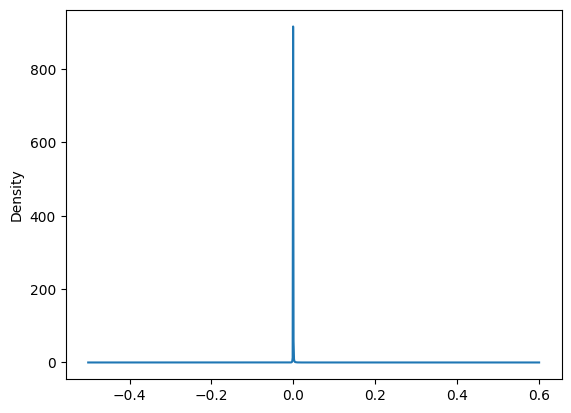

In [17]:
df['NIE_scores'].plot.kde()

In [21]:
df.head()

,Neuron_ids,NIE_scores
0,L-11-I-877,0.325554
1,L-2-AO-308,0.166183
2,L-3-I-906,0.062301
3,L-11-Q-128,0.060278
4,L-4-I-384,0.051122


In [26]:
topk_df = df.iloc[:num_neurons]

In [27]:
topk_df.shape, df.shape

((4147, 2), (82944, 2))

(<AxesSubplot: ylabel='Density'>,
 count    4147.000000
 mean        0.002268
 std         0.006537
 min         0.000615
 25%         0.000818
 50%         0.001158
 75%         0.002057
 max         0.325554
 Name: NIE_scores, dtype: float64)

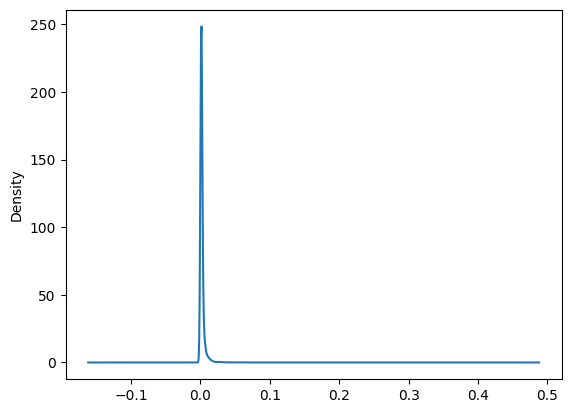

In [30]:
topk_df['NIE_scores'].plot.kde(), topk_df['NIE_scores'].describe()

In [ ]:
topk_df['NIE_scores']